# Task 3 : Occlusion

In [1]:
#import required libraries

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# run the file containing all necessary functions 

%run ../Functions.ipynb

In [3]:
# laod the input file

np_path_XYs = np.genfromtxt(r"D:\Om Saran\ML\adobe\problems\problems\occlusion1.csv",delimiter = ',')

In [4]:
np.unique(np_path_XYs[:,0])

array([0., 1.])

In [5]:
# find the no of polylibe curves present in input shape

size = len(np.unique(np_path_XYs[:,0]))
size

2

In [6]:
# store the curves in a list XY[]

XY = []
for i in range(size):
    new_path = np_path_XYs[np_path_XYs[:,0] == i][:,2:]
    XY.append(new_path)
len(XY)

2

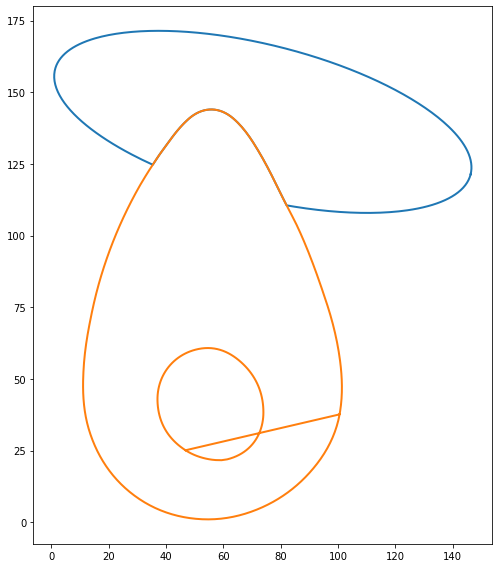

In [7]:
# plot the input shape

fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
for i in range(size):
    ax.plot (XY[i][:, 0], XY[i][:, 1], linewidth =2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show() 

In [8]:
import numpy as np

def split_curve(curve, break_index):
    if 0 < break_index < len(curve) - 1:
        return curve[:break_index + 1], curve[break_index + 1:]
    elif break_index == len(curve) - 1:
        return curve[:break_index + 1], []
    else:
        return curve, []

def calculate_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def calculate_curvature(curve, interval=1.0):
    selected_points = [curve[0]]
    total_distance = 0.0

    for i in range(1, len(curve)):
        distance = calculate_distance(curve[i], selected_points[-1])
        total_distance += distance
        
        if total_distance >= interval:
            selected_points.append(curve[i])
            total_distance = 0.0
    
    curvatures = []
    for i in range(1, len(selected_points) - 1):
        prev_point = selected_points[i - 1]
        curr_point = selected_points[i]
        next_point = selected_points[i + 1]
        
        vector1 = np.array(curr_point) - np.array(prev_point)
        vector2 = np.array(next_point) - np.array(curr_point)
        
        angle = np.arccos(np.clip(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)), -1.0, 1.0))
        
        curvature = angle / (np.linalg.norm(vector1) + np.linalg.norm(vector2))
        curvatures.append(curvature)
    
    return [0] + curvatures + [0]

def find_curvature_break_points(curve, curvature_threshold=0.1, exclusion_distance=5):
    curvatures = calculate_curvature(curve)
    break_points = []
    excluded_indices = set()
    
    for i, curvature in enumerate(curvatures):
        if curvature > curvature_threshold and i not in excluded_indices:
            break_points.append((i, curve[i]))
            
            for j in range(len(curve)):
                if np.linalg.norm(np.array(curve[i]) - np.array(curve[j])) < exclusion_distance:
                    excluded_indices.add(j)
    
    return break_points

def split_curve_by_curvature(curve, curvature_threshold=0.1, exclusion_distance=5, min_length=6, distance_threshold=30):
    if len(curve) == 0:
        return []  # Return an empty list if the curve is empty
    
    def curve_length(curve):
        length = 0.0
        for i in range(1, len(curve)):
            length += calculate_distance(curve[i - 1], curve[i])
        return length
    
    break_points = find_curvature_break_points(curve, curvature_threshold, exclusion_distance)
    break_indices = [bp[0] for bp in break_points]
    
    # Check for distance threshold violations
    for i in range(1, len(curve)):
        if calculate_distance(curve[i - 1], curve[i]) > distance_threshold:
            break_indices.append(i - 1)
    
    break_indices = sorted(set(break_indices))
    
    new_curves = []
    current_curve = curve.copy()
    
    for break_index in break_indices:
        if break_index >= len(current_curve):
            continue
        
        new_curve, remaining_curve = split_curve(current_curve, break_index)
        
        if curve_length(new_curve) < min_length or curve_length(remaining_curve) < min_length:
            continue  # Skip splitting at this break point
        
        if len(new_curve) > 0:
            new_curves.append(new_curve)
        
        current_curve = remaining_curve
    
    if len(current_curve) > 0:
        new_curves.append(current_curve)
    
    return new_curves

def split_all_curves_by_curvature(curves, curvature_threshold=0.1, exclusion_distance=5, min_length=6, distance_threshold=30):
    all_new_curves = []
    
    for curve in curves:
        new_curves = split_curve_by_curvature(curve, curvature_threshold, exclusion_distance, min_length, distance_threshold)
        all_new_curves.extend(new_curves)
    
    return all_new_curves


In [9]:
# split at points where the curvature is high, denoting possible point for start or end of new curve.

cur = len(XY)
XY = split_all_curves_by_curvature(XY)
while len(XY) != cur:
    cur = len(XY)
    XY = split_all_curves_by_curvature(XY)

In [10]:
# new size after splitting

size = len(XY)
size

8

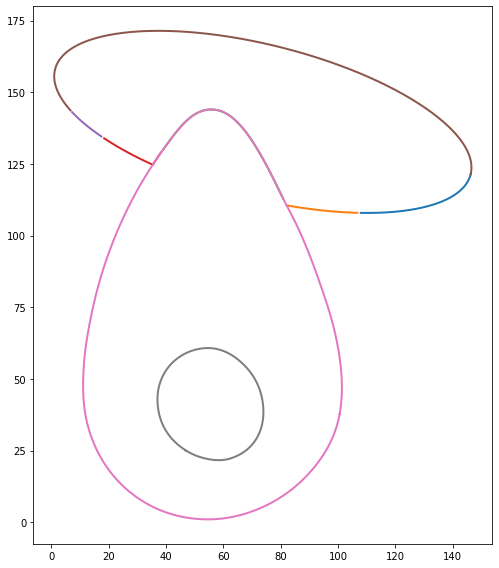

In [11]:
# plot the input after splitting at break points

fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
for i in range(size):
    ax.plot (XY[i][:, 0], XY[i][:, 1], linewidth =2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
        

In [12]:
# make necessary variables to convert the drawing into a graph to detect all possible open and closed curves.

size = len(XY)
start_points = []
end_points = []

for i in range(size):
    a = XY[i][0]
    b = XY[i][len(XY[i])-1]
    start_points.append(a);
    end_points.append(b);

curve_num = {}
for i in range(2*size):
    curve_num[i] = i//2

partner = {}
for i in range(0,2*size,2):
    partner[i] = i+1
for i in range(1,2*size,2):
    partner[i] = i-1
    
umap = {}
for i in range(size):
    umap[2*i] = start_points[i]
    umap[2*i +1] = end_points[i]

num_curves = size
# Initialize adjacency list with curve info
adjacency_list = [[] for _ in range(2 * num_curves)]  # 20 nodes for 10 curves

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Build the adjacency list
for i in range(num_curves):
    # Connect each curve's start and end points to each other
    adjacency_list[2 * i].append((2 * i + 1, i))  # Connect start to end
    adjacency_list[2 * i + 1].append((2 * i, i))  # Connect end to start

    for j in range(num_curves):
        if i != j:
            # Check distances for start points
            if euclidean_distance(start_points[i], start_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j, j))
            if euclidean_distance(start_points[i], end_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j + 1, j))
            # Check distances for end points
            if euclidean_distance(end_points[i], start_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j, j))
            if euclidean_distance(end_points[i], end_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j + 1, j))

In [13]:
to_print = []

In [14]:
# find all the open curves present in the shape

num_nodes = len(adjacency_list)
open_curves = find_open_curves(adjacency_list, num_nodes,umap)

In [15]:
len(open_curves)

0

In [16]:
# Load the model for classifying closed curves

from joblib import dump, load
model_open = load('../Models/model_open.joblib')

In [17]:
# Step 1: Collect all indices that need to be removed, since curves that are already a part of s
rem_ind1 = set()

In [18]:
# reconstruct all possible straight lines from open curves and use the model to classify and regularize and save straight lines

for curve_set, node_sequence in open_curves.items():
    new_path = reconstruct_single_curve(node_sequence,umap,XY,partner)
    fv = extract_features(new_path)
    fv = fv.reshape(1, -1)
    shape = model_open.predict(fv)
    print(shape)
#     print(new_path)
    
    if shape == 'straight':
        rem_ind.update(curve_set)
        print(curve_set)
        to_print.append(curve_set)
        corners = [new_path[0], new_path[len(new_path)-1]]
        corners = np.array(corners) 
        ax.plot (corners[:, 0], corners[:, 1], linewidth =2)  

In [19]:
# Step 2: Filter XY[] by removing the curves whose indices are in the set
XY = [curve for i, curve in enumerate(XY) if i not in rem_ind1]

In [20]:
len(XY)

8

In [21]:
# build the graph again with new XY[] list

size = len(XY)
start_points = []
end_points = []

for i in range(size):
    a = XY[i][0]
    b = XY[i][len(XY[i])-1]
    start_points.append(a);
    end_points.append(b);

curve_num = {}
for i in range(2*size):
    curve_num[i] = i//2

partner = {}
for i in range(0,2*size,2):
    partner[i] = i+1
for i in range(1,2*size,2):
    partner[i] = i-1
    
umap = {}
for i in range(size):
    umap[2*i] = start_points[i]
    umap[2*i +1] = end_points[i]

num_curves = size
# Initialize adjacency list with curve info
adjacency_list = [[] for _ in range(2 * num_curves)]  # 20 nodes for 10 curves

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Build the adjacency list
for i in range(num_curves):
    # Connect each curve's start and end points to each other
    adjacency_list[2 * i].append((2 * i + 1, i))  # Connect start to end
    adjacency_list[2 * i + 1].append((2 * i, i))  # Connect end to start

    for j in range(num_curves):
        if i != j:
            # Check distances for start points
            if euclidean_distance(start_points[i], start_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j, j))
            if euclidean_distance(start_points[i], end_points[j]) < 5:
                adjacency_list[2 * i].append((2 * j + 1, j))
            # Check distances for end points
            if euclidean_distance(end_points[i], start_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j, j))
            if euclidean_distance(end_points[i], end_points[j]) < 5:
                adjacency_list[2 * i + 1].append((2 * j + 1, j))

In [22]:
# import the model for closed curves classification

from tensorflow.keras.models import load_model
model_closed = load_model('../Models/model_closed.h5')

In [23]:
# find all the closed curves

# Number of nodes
num_nodes = len(adjacency_list)

# Find all closed curves
closed_curves = find_closed_curves(adjacency_list, num_nodes)
len(closed_curves)


3

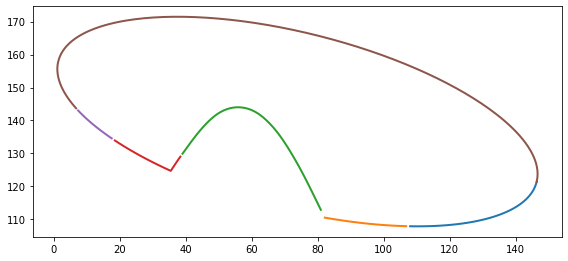

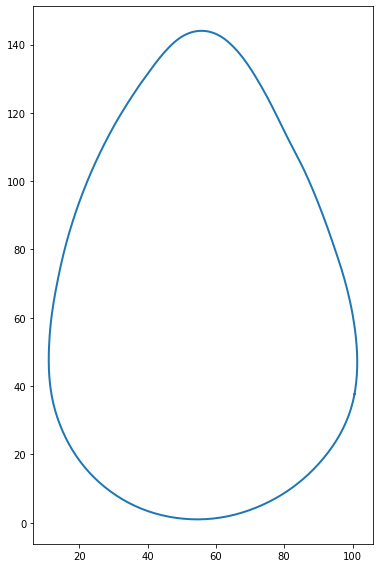

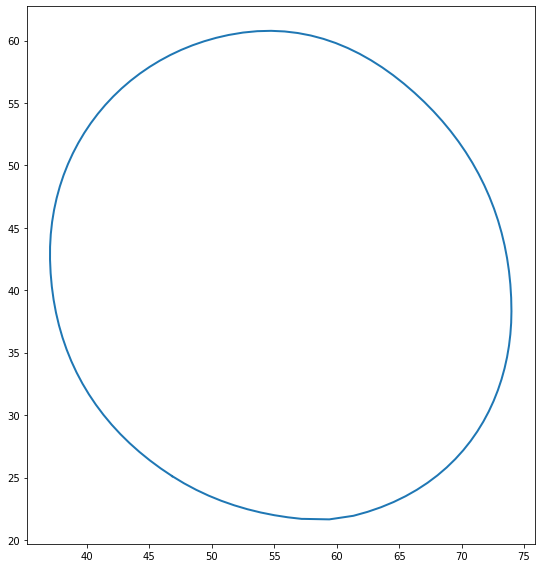

In [24]:
#plot all the closed curves

for i, (curve_set, path) in enumerate(closed_curves.items()):
    fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
    for el in curve_set:
        ax.plot (XY[el][:, 0], XY[el][:, 1], linewidth =2)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [25]:
label_map = { 0 : 'circle',  1 : 'ellipse',  2:  'irregular',  3 : 'rectangle', 4: 'regular',  5 : 'star'}

In [26]:
for_sym = []

In [27]:
# reconstruct all possible closed regular curves from open curves and use the model to classify and regularize
# and save regular closed curves

rem_ind2 = set() 

for curve_set, node_sequence in closed_curves.items():
    new_path = reconstruct_single_curve(node_sequence,umap,XY,partner)
    for_sym.append(new_path)
    #print(len(new_path))
    #print(type(new_path))
    #print(type(new_path[0]))
    data = np.array([convert_points_to_image(new_path,224)])
    data = np.stack([data] * 3, axis=-1)
    #print(data.shape)
    out = model_closed.predict(data)
    num = np.argmax(out)
    shape = label_map[num]
    #print(shape)
    #     print(new_path)
    
    if shape == 'rectangle':
        #print(curve_set)
        rem_ind2.update(curve_set)
        corners = find_corners(new_path)
        #print(corners)
        reg_corners = adjust_to_perfect_rectangle(corners)
        reg_corners = np.vstack([reg_corners, reg_corners[0]])
        to_print.append(reg_corners)
        ax.plot(reg_corners[:, 0], reg_corners[:, 1], linewidth =2)
        
    if shape == 'circle':
        rem_ind2.update(curve_set)
        #print(curve_set)
        radius = np.mean(distances_to_centroid(new_path))
        centre = new_path.mean(axis =0)
        points = generate_circle_points(centre, radius)
        points = np.vstack([points,points[0]])
        to_print.append(points)
        ax.plot (points[:, 0], points[:, 1], linewidth =2)
    
    if shape == 'star':
        rem_ind2.update(curve_set)
        #print(curve_set)
        corners = find_corners(new_path)
        corners = np.vstack((corners, corners[0]))
        to_print.append(corners)
        ax.plot (corners[:, 0], corners[:, 1], linewidth =2)
    
    if shape == 'regular':
        #print(curve_set)
        corners = find_corners(new_path)
        corners = remove_close_corners(corners)
#         print(corners)
        centroid = corners.mean(axis =0)
        points = generate_polygon_points_on_circle(corners,centroid)
        if points ==0:
            continue
        rem_ind2.update(curve_set)
        to_print.append(points)
        points = np.vstack((points, corners[0]))
        ax.plot (points[:, 0], points[:, 1], linewidth =2)
#         print(points) 

In [28]:

# Step 2: Filter XY[] by removing the curves whose indices are in the set
XY = [curve for i, curve in enumerate(XY) if i not in rem_ind2]


In [29]:
len(XY)

8

In [30]:
from tensorflow.keras.models import load_model
model_occ = load_model('../Models/model_occ.h5')

In [31]:
label_map2 = {0 : 'none',  1: 'occ_circle',  2 : 'occ_ellipse'}

occ_ellipse


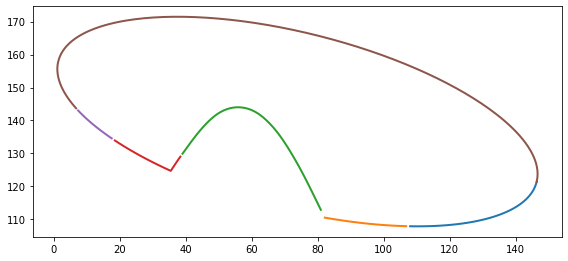

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
none
none


In [32]:
rem_ind3 = set() 

for curve_set, node_sequence in closed_curves.items():
    new_path = reconstruct_single_curve(node_sequence,umap,XY,partner)
    for_sym.append(new_path)
    #print(len(new_path))
    #print(type(new_path))
    #print(type(new_path[0]))
    data = np.array([convert_points_to_image(new_path,224)])
    data = np.stack([data] * 3, axis=-1)
    #print(data.shape)
    out = model_occ.predict(data)
    num = np.argmax(out)
    shape = label_map2[num]
    print(shape)
    #     print(new_path)
    
    if shape == 'occ_rectangle':
        #print(curve_set)
        rem_ind3.update(curve_set)
        corners = find_corners(new_path)
        #print(corners)
        reg_corners = adjust_to_perfect_rectangle(corners)
        reg_corners = np.vstack([reg_corners, reg_corners[0]])
        to_print.append(reg_corners)
        ax.plot(reg_corners[:, 0], reg_corners[:, 1], linewidth =2)
        
    if shape == 'occ_circle':
        rem_ind3.update(curve_set)
        #print(curve_set)
        radius = np.mean(distances_to_centroid(new_path))
        centre = new_path.mean(axis =0)
        points = generate_circle_points(centre, radius)
        points = np.vstack([points,points[0]])
        to_print.append(points)
        ax.plot (points[:, 0], points[:, 1], linewidth =2)
    
    if shape == 'occ_star':
        rem_ind3.update(curve_set)
        #print(curve_set)
        corners = find_corners(new_path)
        corners = np.vstack((corners, corners[0]))
        to_print.append(corners)
        ax.plot (corners[:, 0], corners[:, 1], linewidth =2)
    
    if shape == 'occ_regular':
        #print(curve_set)
        corners = find_corners(new_path)
        corners = remove_close_corners(corners)
#         print(corners)
        centroid = corners.mean(axis =0)
        points = generate_polygon_points_on_circle(corners,centroid)
        if points ==0:
            continue
        rem_ind3.update(curve_set)
        to_print.append(points)
        points = np.vstack((points, corners[0]))
        ax.plot (points[:, 0], points[:, 1], linewidth =2)
#         print(points)

    if shape == 'occ_ellipse':
        fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
        for el in curve_set:
            ax.plot (XY[el][:, 0], XY[el][:, 1], linewidth =2)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()
        #print(curve_set)
        x = new_path[:, 0]
        y = new_path[:, 1]
        print(type(x))
        print(type(y))
        center, semi_major_axis, semi_minor_axis, slope = calculate_ellipse_parameters(x, y)
        semi_minor_axis = semi_minor_axis + 10
        ellipse_points = generate_ellipse(center, semi_major_axis, semi_minor_axis, slope)
        ellipse_points = np.vstack([ellipse_points,ellipse_points[0]])
        rem_ind3.update(curve_set)
        to_print.append(ellipse_points)
         

In [33]:
# Step 2: Filter XY[] by removing the curves whose indices are in the set
XY = [curve for i, curve in enumerate(XY) if i not in rem_ind3]

In [34]:
len(XY)

2

## Final output :

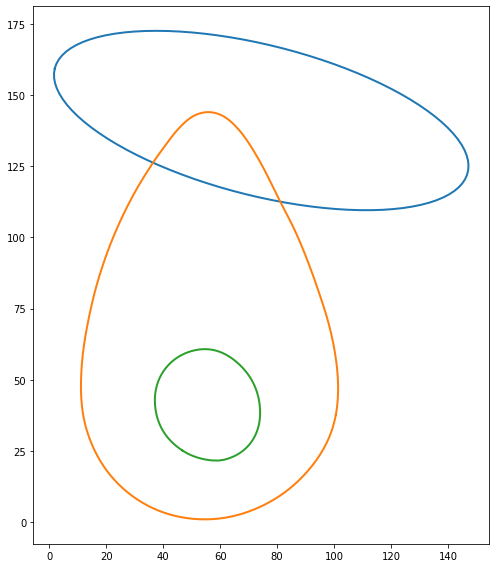

In [35]:
fig , ax = plt . subplots ( tight_layout =True , figsize =(8 , 8))
for i in range(len(to_print)):
    ax.plot (to_print[i][:, 0], to_print[i][:, 1], linewidth =2)


for i in range(len(XY)):
    ax.plot (XY[i][:, 0], XY[i][:, 1], linewidth =2)  
    
plt.gca().set_aspect('equal', adjustable='box')
plt.show()    